Scoring in next 10 actions model - Model Evaluation - GBM

In [8]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [9]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from exp_vaep.exp_vaep_config import exp_vaep_modelling_v2_file_path
from exp_vaep.domain.contracts.modelling_data_contract import ModellingDataContract
from exp_vaep.domain.modelling.supermodel import SuperXGBRegressor
from exp_vaep.domain.modelling.model_evaluation import XGBRegressorEvaluator
from exp_vaep.domain.preprocessing.preprocessing import *

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


New Model

In [10]:
new_version = 2
model_name = "exp_vaep_scoring"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/models/"
preproc_file_path = ""

Comparison Model

In [11]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [12]:
RESPONSE = ModellingDataContract.RESPONSE_SCORES

Features

In [13]:
FEATURES = ModellingDataContract.feature_list_scores

Load Data

In [15]:
modelling_data = pd.read_csv(exp_vaep_modelling_v2_file_path)
modelling_data.tail()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,xScore,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Unconteste

Preprocess Data

In [16]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [17]:
training_data = modelling_data[modelling_data[RESPONSE+"TrainingSet"]]
test_data = modelling_data[modelling_data[RESPONSE+"TestSet"]]
cal_data = modelling_data[modelling_data[RESPONSE+"ValidationSet"]]

In [18]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [19]:
y_train.mean(), y_test.mean(), y_cal.mean()

(0.7900926407904131, 0.7884963794824171, 0.7944290721466609)

In [20]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]
X_cal_preproc = X_cal[FEATURES]

Load Model

In [21]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

Get Predictions

In [22]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

Compare Model

In [23]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [24]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds_exp_scores':'old_preds'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds_exp_scores':'old_preds'})

In [25]:
# training_data.shape, compare_train_data.shape, test_data.shape, compare_test_data.shape

In [26]:
# compare_test_data.head()

In [27]:
# training_data = pd.merge(training_data, compare_train_data[["match_id", "quarter", "quarter_seconds", "overall_seconds", "team", "player", 'start_x', 'start_y', 'end_x', 'end_y', "action_type", "outcome_type", "xScore", 'old_preds']], how = "left", on = ["match_id", "quarter", "quarter_seconds", "overall_seconds", "team", "player", 'start_x', 'start_y', 'end_x', 'end_y', "action_type", "outcome_type", "xScore",])
# test_data = pd.merge(test_data, compare_test_data[["match_id", "quarter", "quarter_seconds", "overall_seconds", "team", "player", 'start_x', 'start_y', 'end_x', 'end_y', "action_type", "outcome_type", "xScore", 'old_preds']], how = "left", on = ["match_id", "quarter", "quarter_seconds", "overall_seconds", "team", "player", 'start_x', 'start_y', 'end_x', 'end_y', "action_type", "outcome_type", "xScore",])

Evaluate Model

In [28]:
training_data['xgb_preds'] = train_preds

train_xgb_evals = XGBRegressorEvaluator(model = super_xgb,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_preds",
                                    #    compare_name='old_preds',
                                       )


In [29]:
test_data['xgb_preds'] = test_preds

test_xgb_evals = XGBRegressorEvaluator(model = super_xgb,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_preds",
                                    #    compare_name = "old_preds",
                                       )

Model Averages

In [30]:
training_data[[RESPONSE, 'xgb_preds']].describe()

,exp_scores,xgb_preds
count,660577.000000,660577.000000
mean,0.790093,0.768133
std,1.501094,0.862196
min,0.000000,-0.509903
25%,0.000000,0.130786
50%,0.000000,0.465854
75%,0.000000,1.122052
max,5.740831,5.574040


In [31]:
test_data[[RESPONSE, 'xgb_preds']].describe()

,exp_scores,xgb_preds
count,206431.000000,206431.000000
mean,0.788496,0.768219
std,1.498333,0.862229
min,0.000000,-0.409206
25%,0.000000,0.131072
50%,0.000000,0.465747
75%,0.000000,1.121119
max,5.740831,5.574040


Plots

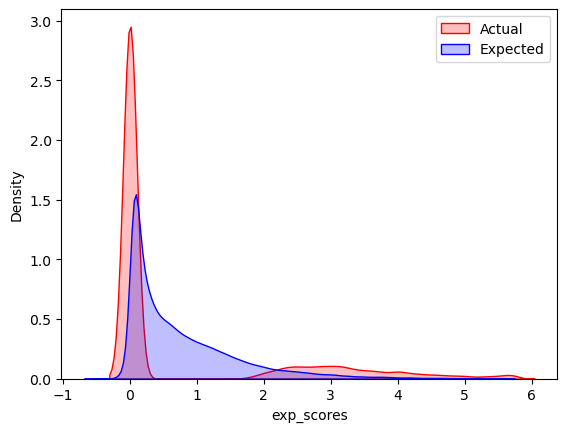

In [32]:
train_xgb_evals.plot_distribution()

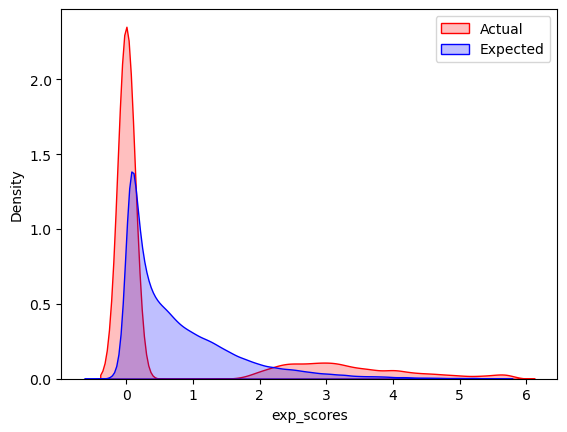

In [33]:
test_xgb_evals.plot_distribution()

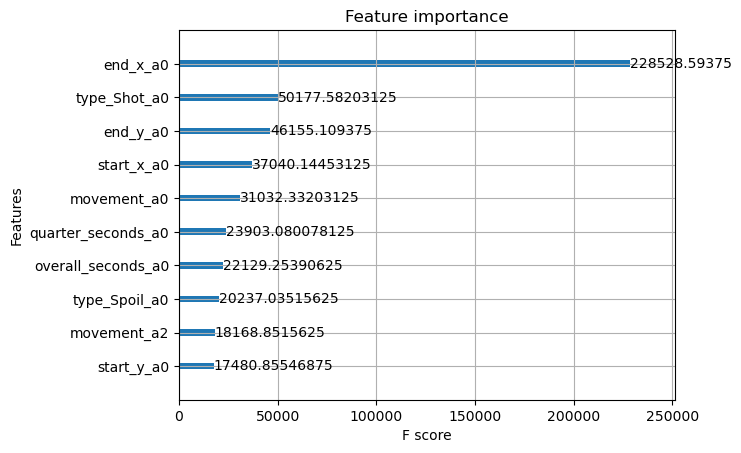

In [34]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

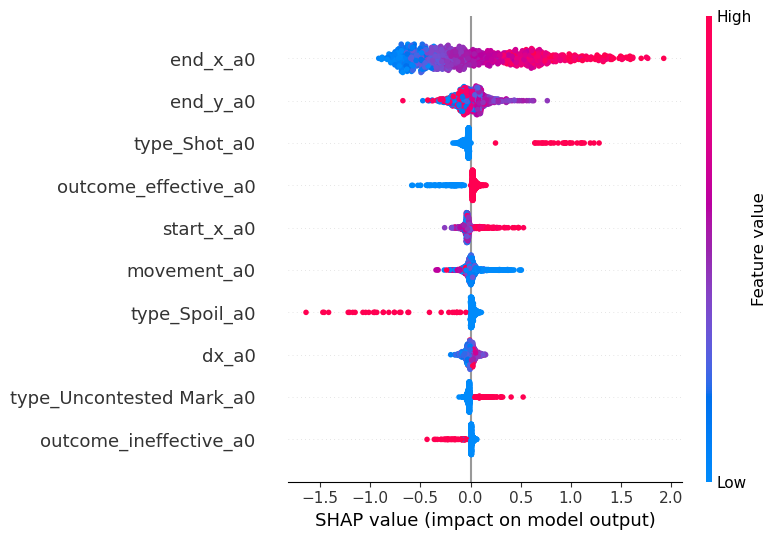

In [35]:
train_xgb_evals.plot_shap_summary_plot(sample=1000)

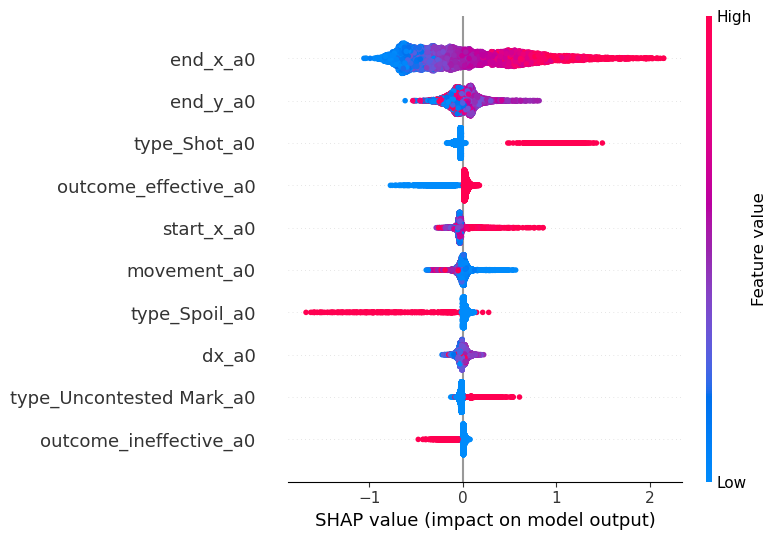

In [36]:
test_xgb_evals.plot_shap_summary_plot(sample=10000)

In [37]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['end_x_a0',
 'end_y_a0',
 'type_Shot_a0',
 'outcome_effective_a0',
 'start_x_a0',
 'movement_a0',
 'type_Spoil_a0',
 'dx_a0',
 'type_Uncontested Mark_a0',
 'outcome_ineffective_a0']

In [ ]:
# for col in top_10_features:
#     test_xgb_evals.plot_pdp([col])

In [ ]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

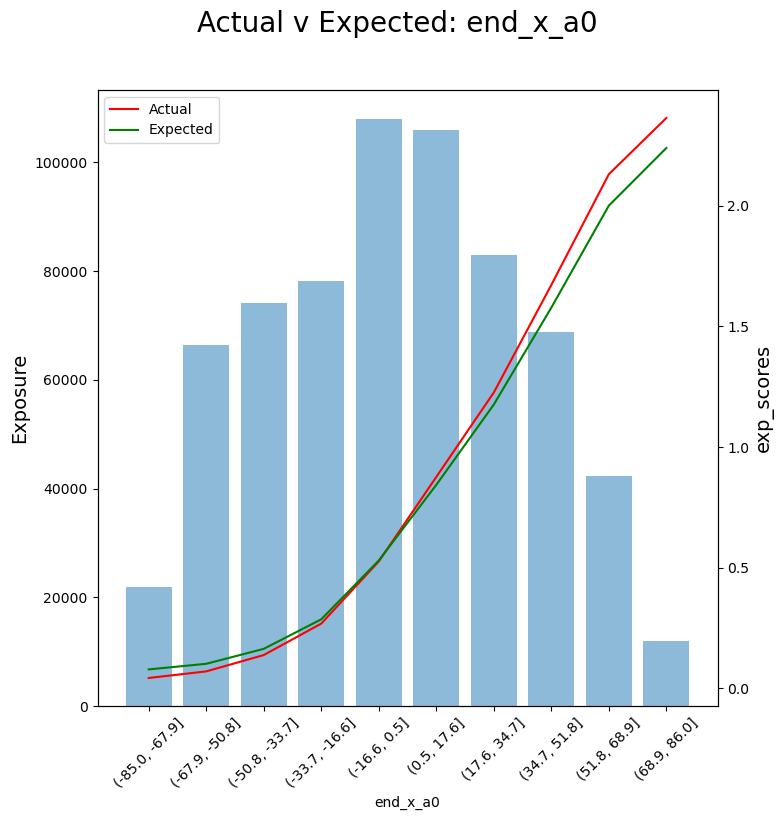

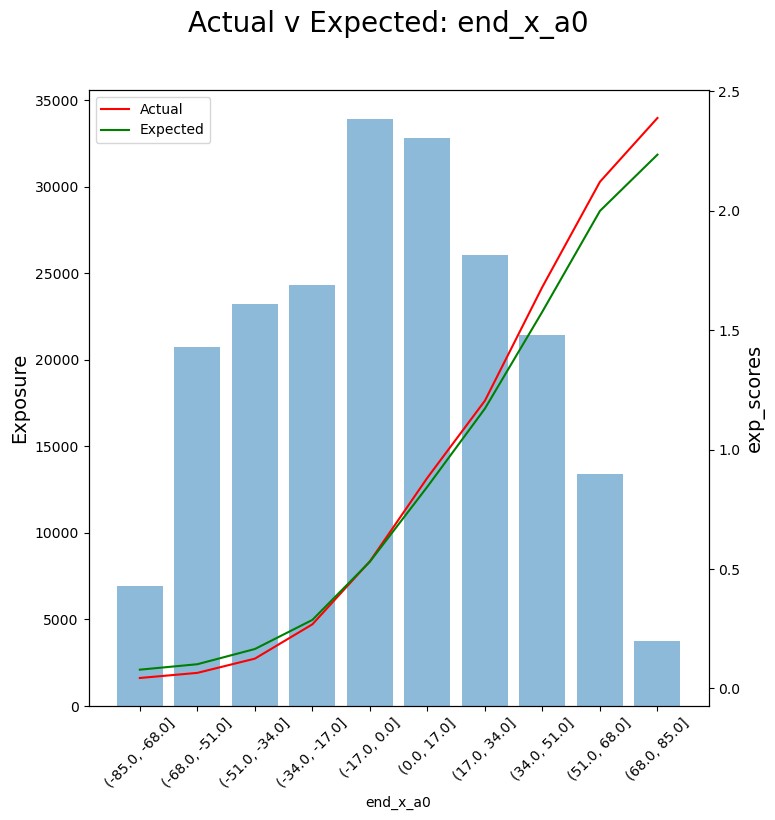

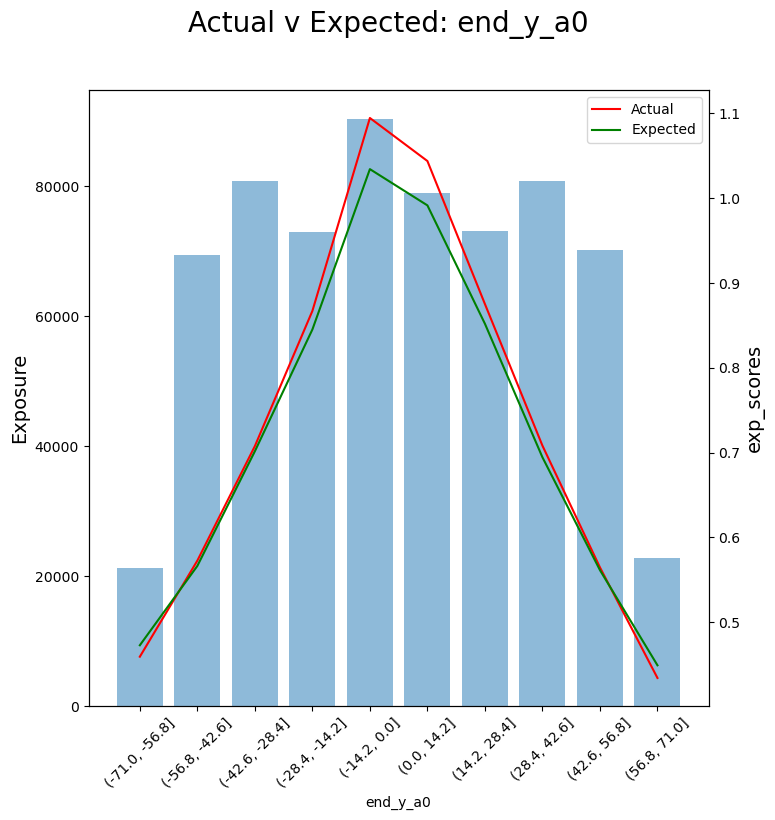

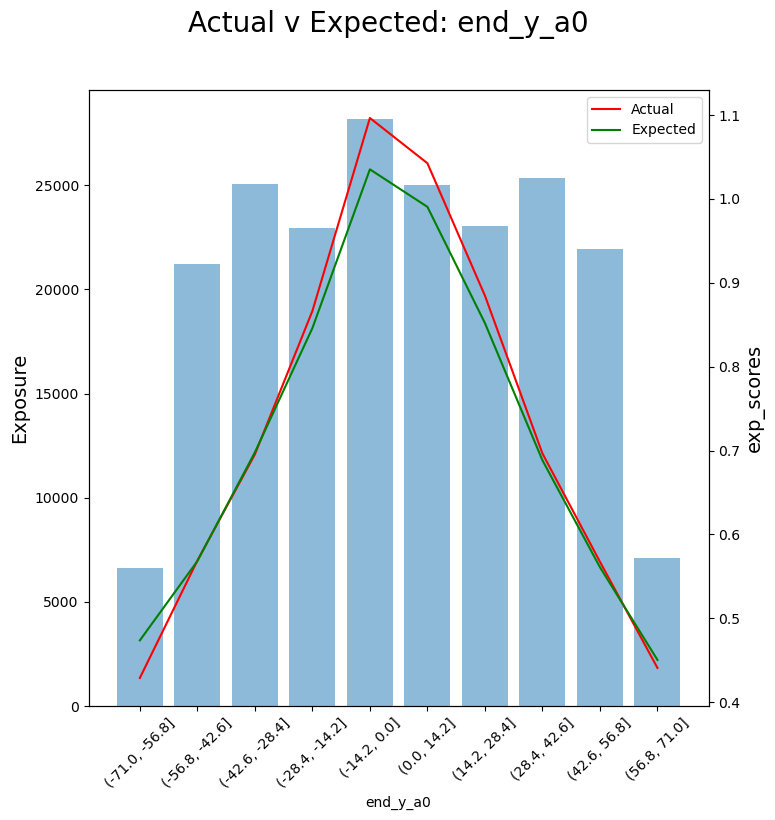

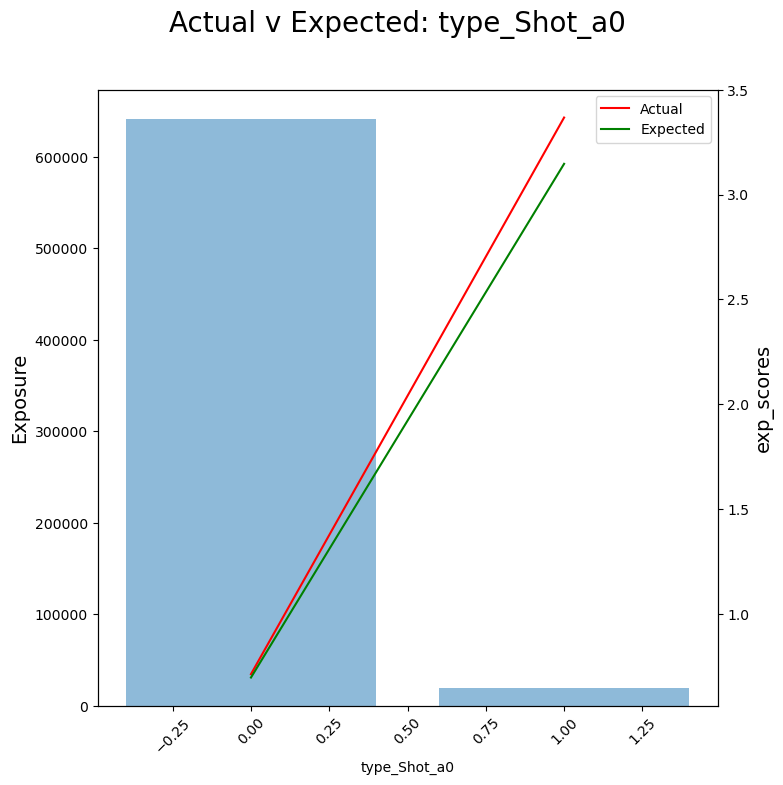

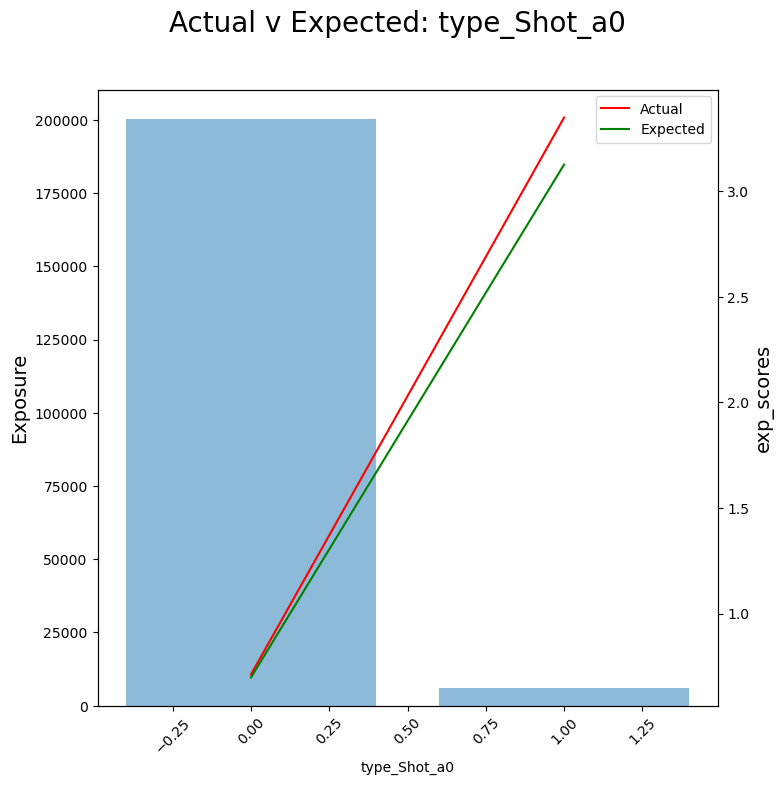

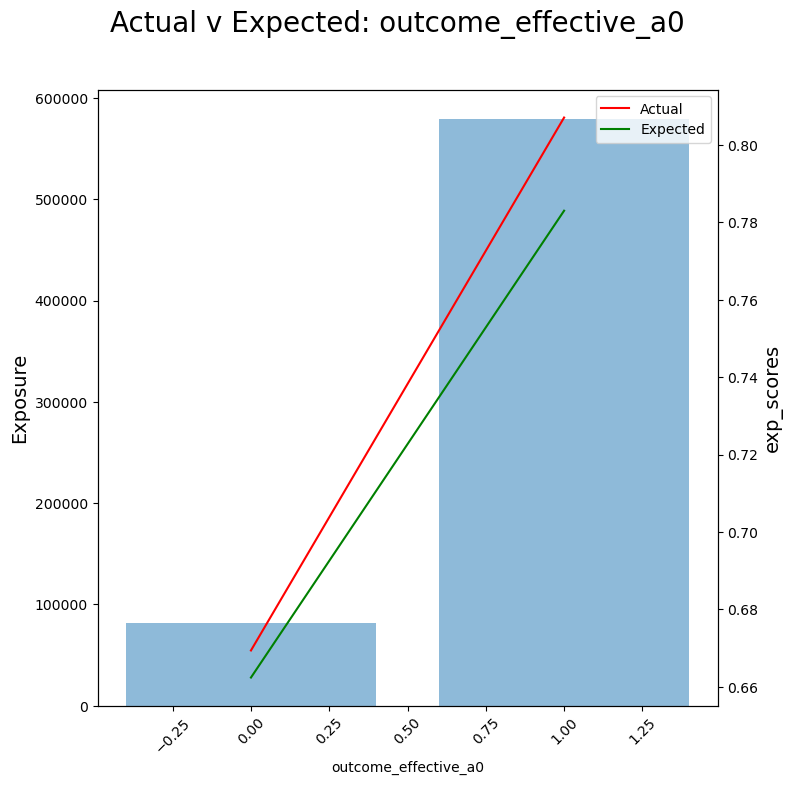

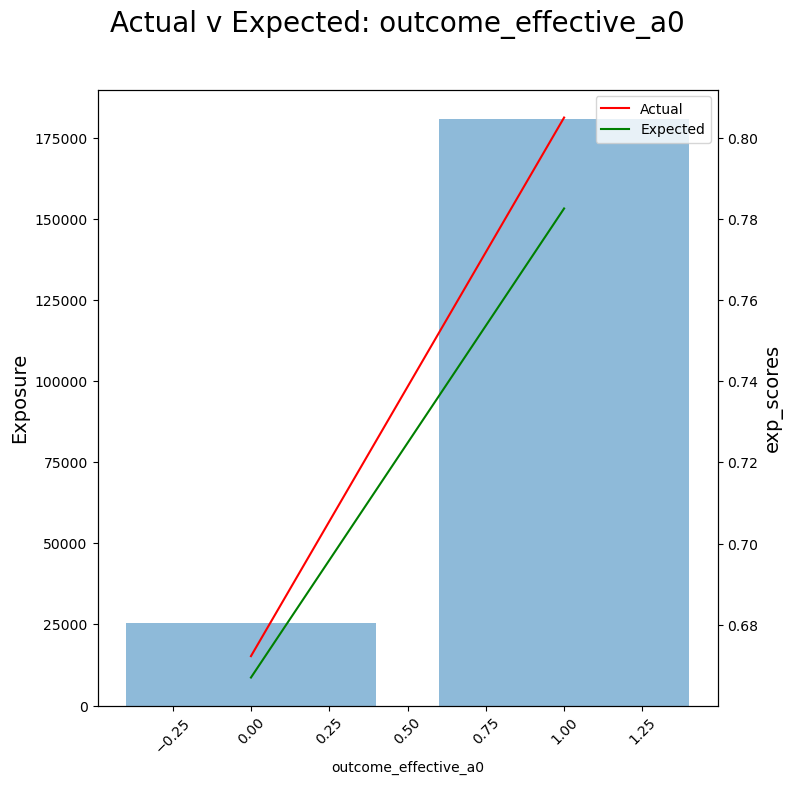

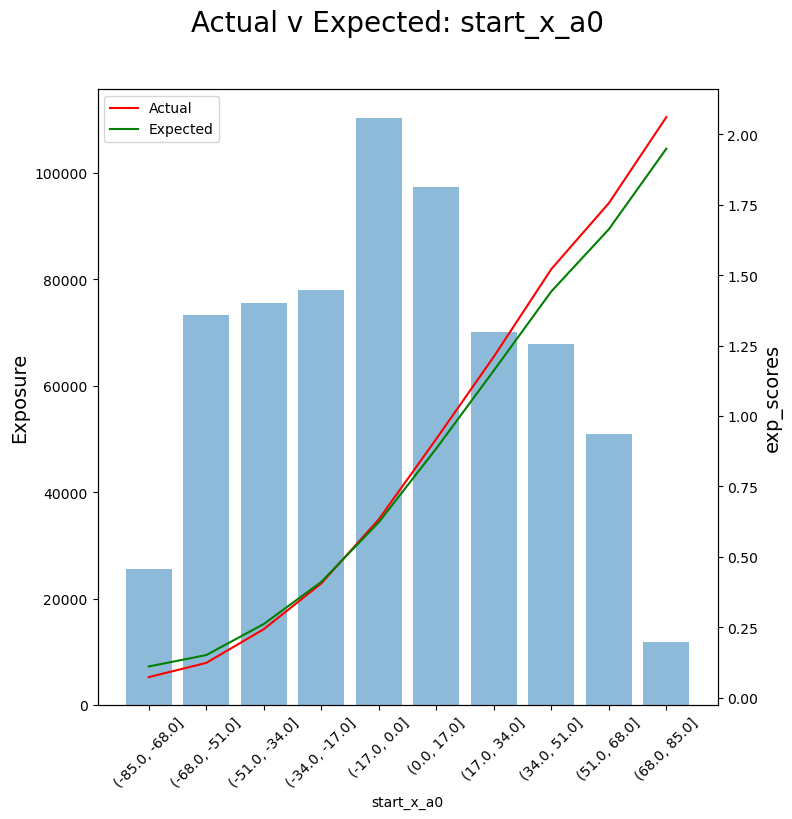

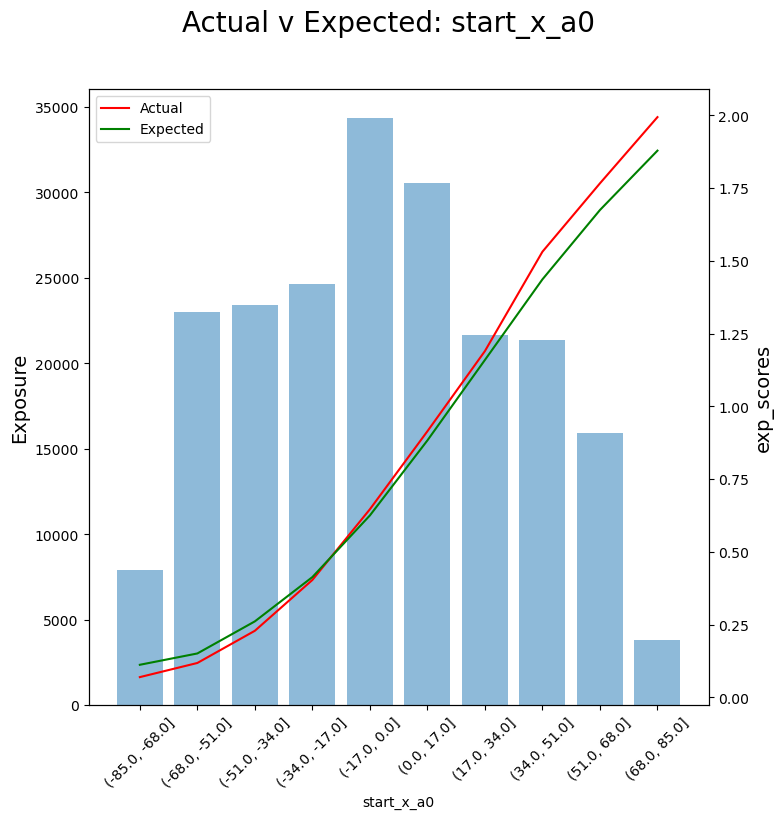

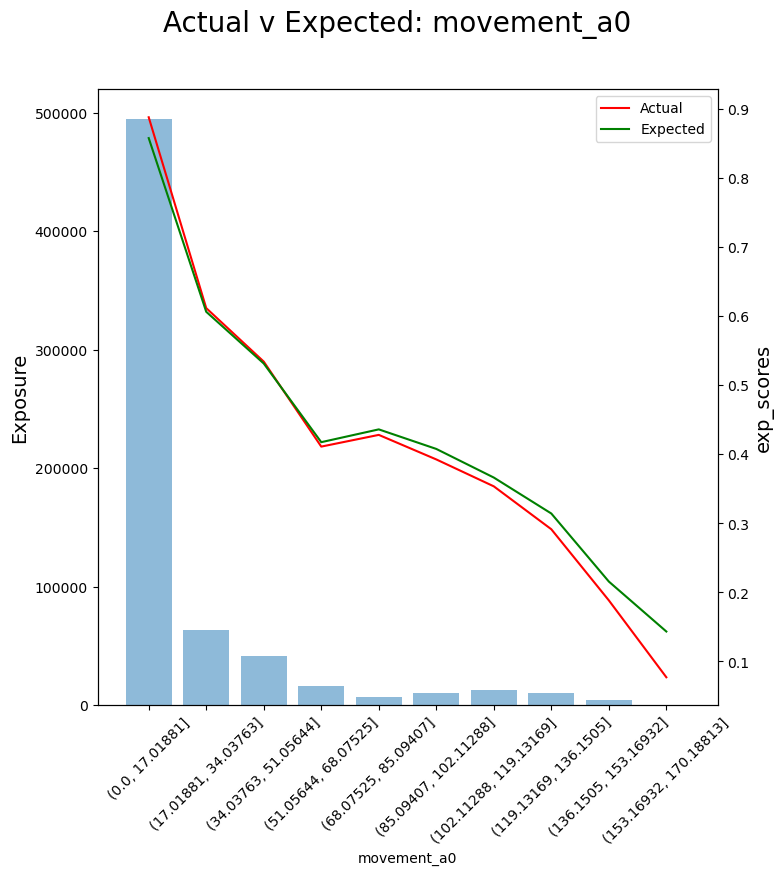

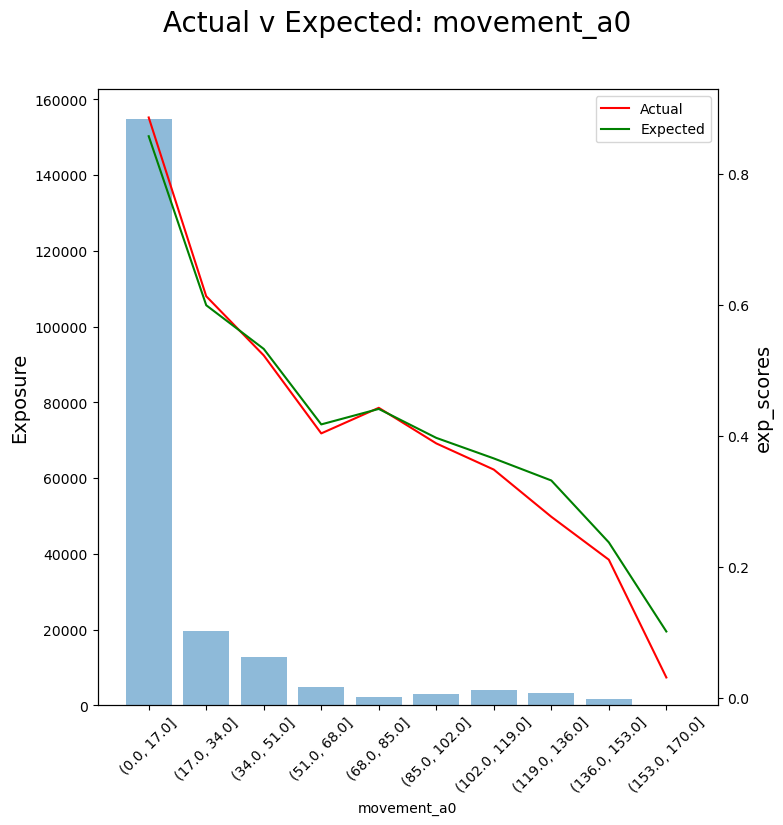

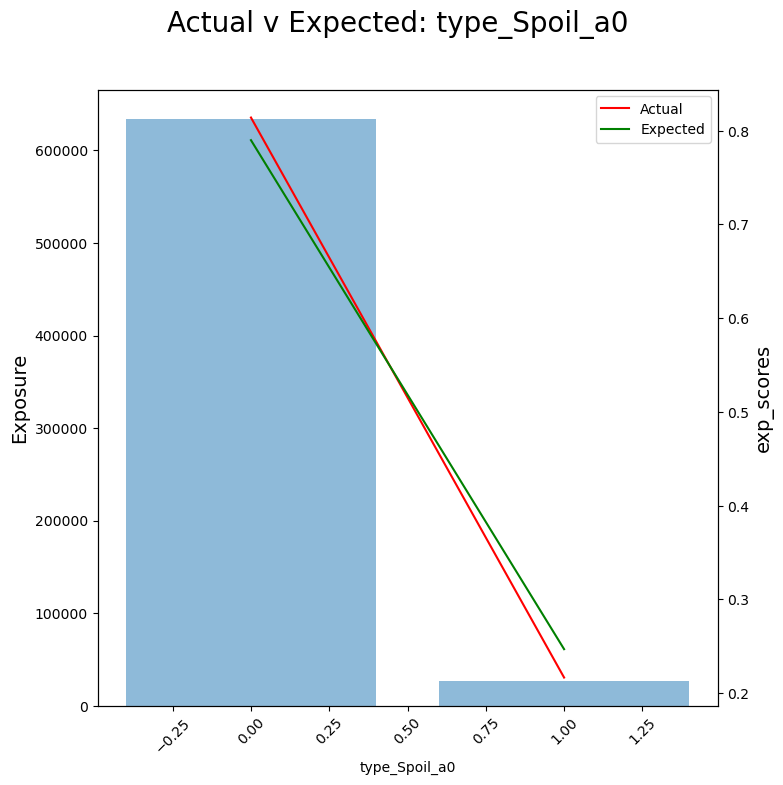

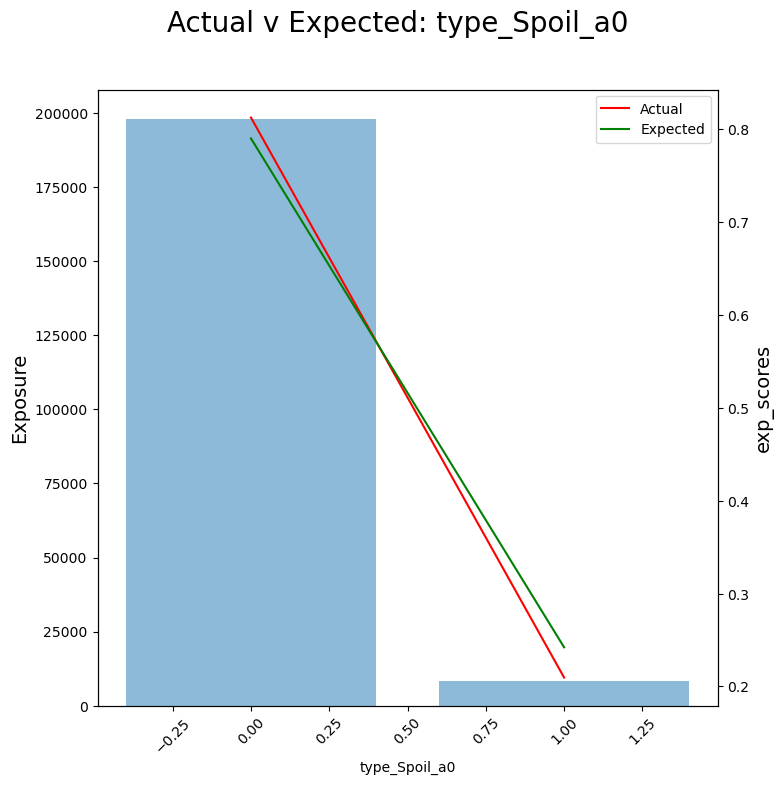

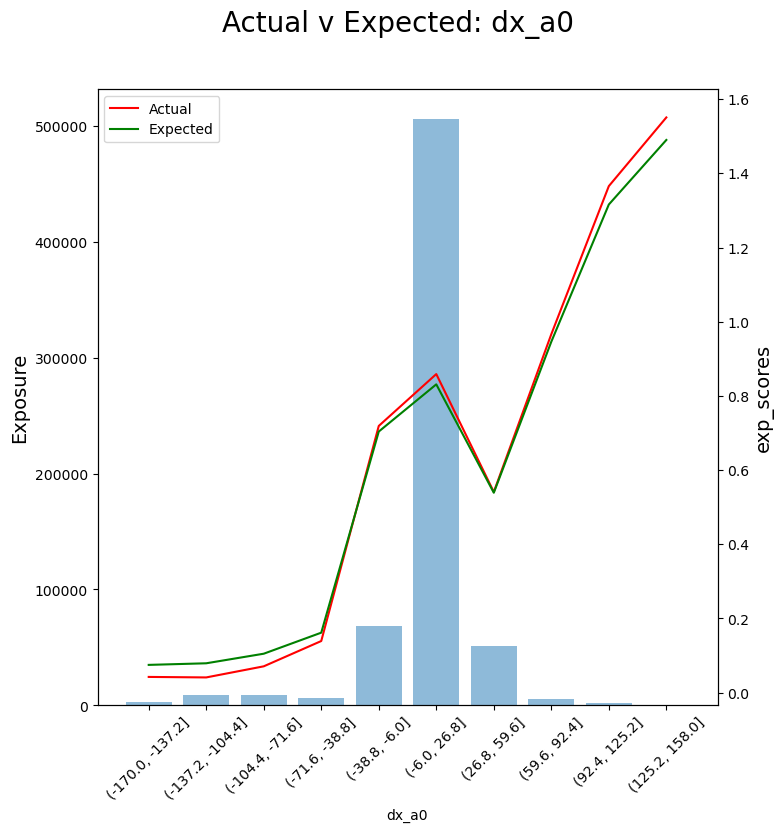

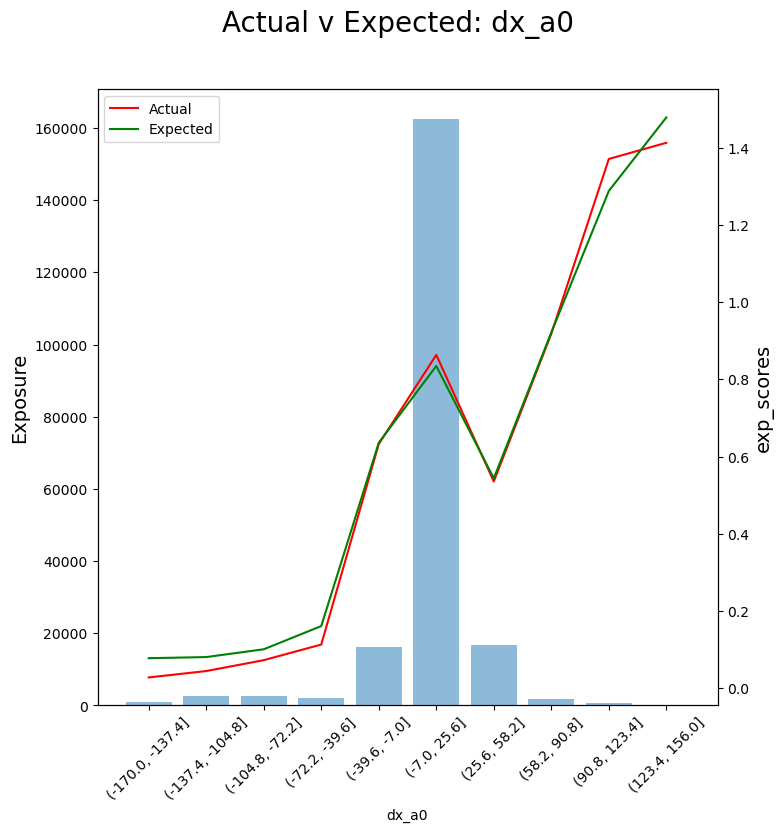

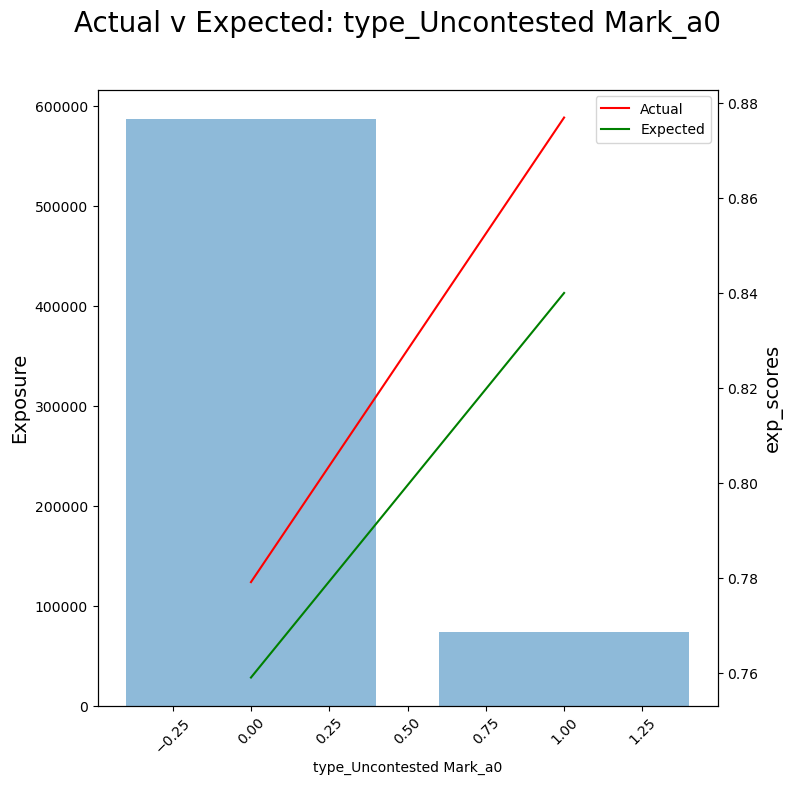

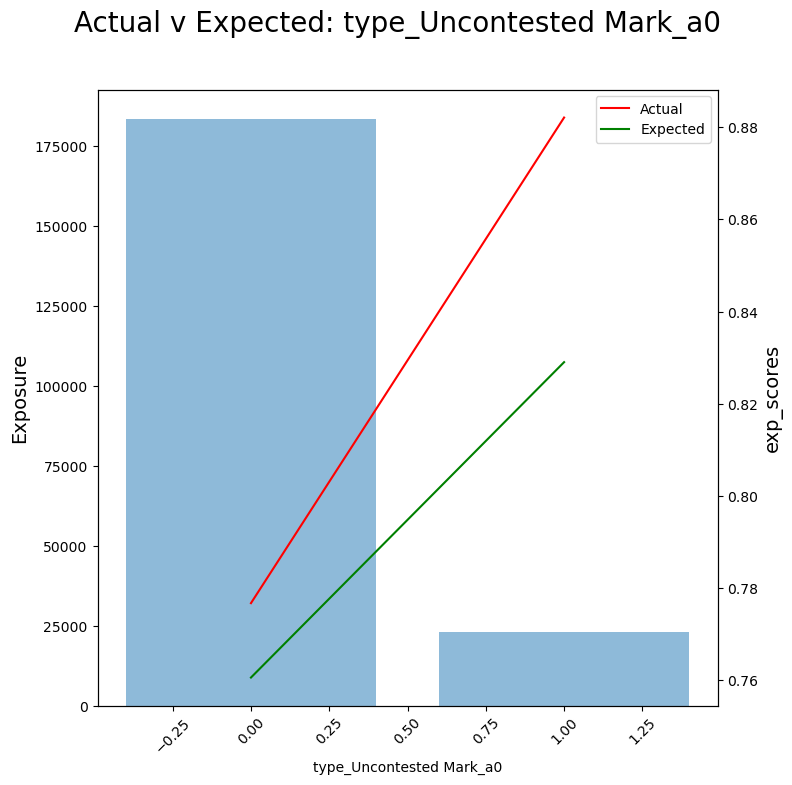

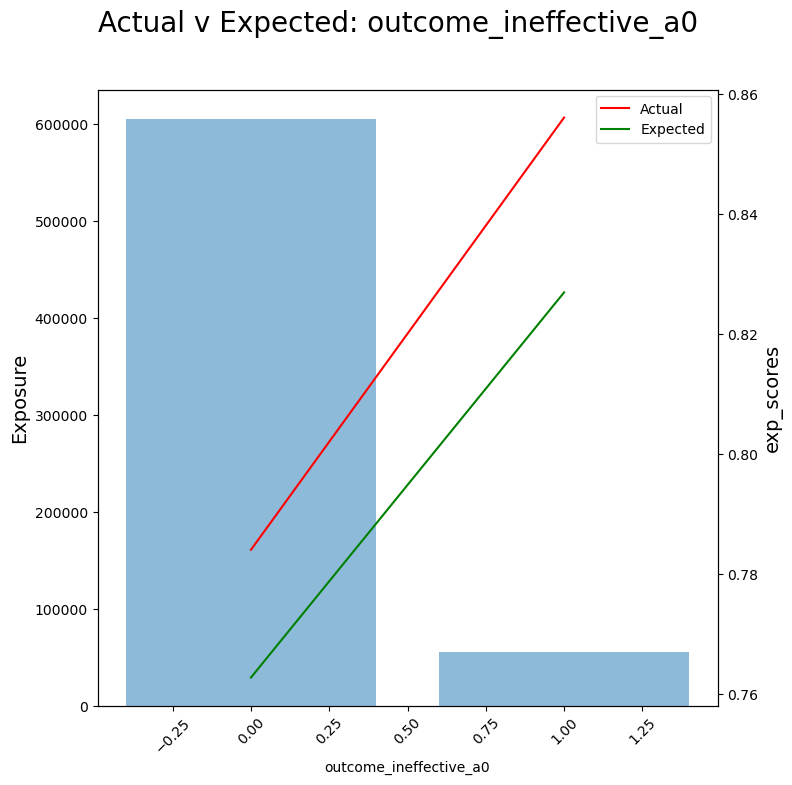

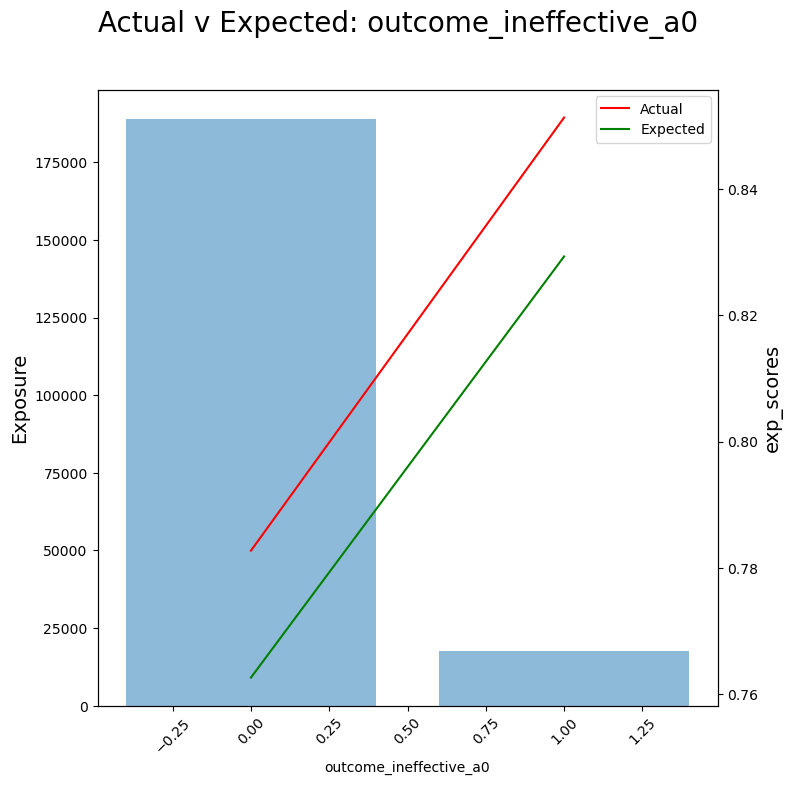

In [38]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [39]:
train_xgb_evals.get_mae(), test_xgb_evals.get_mae()

(0.7570424757478932, 0.7832218430941136)

In [40]:
train_xgb_evals.get_mse(), test_xgb_evals.get_mse() 

(1.3614027532306647, 1.46013870834777)

In [41]:
train_xgb_evals.get_r2_score(), test_xgb_evals.get_r2_score() 

(0.3958132158815675, 0.34960125764882466)